# What is clustering?

Human beings like to organize things into groups. It's universally acknowledged truth. In data analysis, we may divide things by city of origin, or gender, or create age groups, among others. These are examples of manual clustering, where we define the bounds (the criteria that separate groups) ourselves.

When it comes to dealing with more than one variable at a time, however, it is easier to let an algorithm organize data points with similar characteristics into groups. Some algorithms use _hard clustering_, where each data point is assigned to only one cluster; others use _soft clustering_, where each data point is assigned a degree of membership for every cluster. We will mostly review hard clustering options here. Either way, an algorithmic cluster is a set of data points that have been determined to be more similar to one another than to other data points. The way that similarity is determined is what differentiates the various clustering methods.

Clustering is useful as a method of generating features for a model, as well as a way of learning more about associations between data points. However, there are also some caveats: First, it is important to normalize data before clustering them, so that all variables have equal potential impact on the clustering algorithm. And second, just because an algorithm can find a certain number of clusters doesn't mean those clusters are meaningful. If the number of clusters we request is too large, or the algorithm grabs too many clusters, groups will start to split on trivial differences, leading to overfitting. If there are too few clusters, we won't get much information from them, and real differences between data points can be obscured.

We can also cluster hierarchically, where lower-level clusters are formed and then grouped into higher-level clusters. This can be useful if we are interested in subdivisions within a larger cluster. For example, imagine we have four clusters: young men, young women, older men, and older women. If all we have are those four clusters, we don't really know whether the young men are more similar to the young women, or to the older men. To find this out, we could do hierarchical clustering, where we first have the four lower-level clusters, but then we also add two high-level clusters (men vs women, or young vs old) that would show us which lower-level clusters have more in common.

Now let's get to clustering!

## Clustering with K-Means

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
%matplotlib inline

$k$-means is a mathematically straightforward but computationally intensive hard-clustering method for grouping data into clusters of similar data points with similar variances.  It uses a cost function called the *inertia*, and the algorithm tries to choose means (called *centroids*) that minimize the inertia.  If you recall the lesson on linear regression, the formula for inertia may be familiar:

$$\sum(\bar{x}_c - x_i)^2$$

In words, the inertia is the sum of the squared differences between the centroid of a cluster (the mean $\bar{x}_c$) and the data points in the cluster ($x_i$).  The goal is to define cluster means so that the distance between a cluster mean and all the data points within the cluster is as small as possible.

So the *means* in $k$-means refers to the centroids.  The $k$ is the number of centroids (and thus, the number of clusters) the algorithm works with, which is provided by the user.  It's a pretty literal name.

How do you pick $k$?  Basically through trial and error.   Pick a $k$, look at the solution, see if it makes sense, then try other $k$'s.  Clusters representing "real" divisions in the data will be stable across training set and test set.

## How the algorithm works

$k$-means is an iterative algorithm that eventually converges on a solution.  It begins by choosing $k$ centroids at random, then repeats the following two steps until convergence:

1. Assign each data point to the nearest centroid
2. Create new centroids by taking the mean of all the data points assigned to each centroid

The algorithm stops when the difference between the old and new centroids is lower than a given threshold.

Like other iterative algorithms with a random start, bad starting centroid values can cause $k$-means to arrive at a lousy solution.  As a result, it is recommended to try the algorithm a few times with different starting centroids.  The sklearn implementation has a nifty `kmeans++` option for initializing centroids that are distant from each other, which is less likely to end in a flawed solution.

## Assumptions made by $k$-means models

$k$-means assumes that the underlying "true" clusters are radially symmetrical (isotropic), meaning that they are uniform in all directions and the edges curve outward.  It also assumes all clusters have similar variances.  See these [pictures of clusters](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py) that do and do not fit the $k$-means isotropic and variance assumptions.  

## Speed

High-dimensional data tends to make $k$-means run more slowly because it is more computationally demanding to measure the distance between each data point and the mean in a higher-dimensional space. A common practice is to run a PCA on the data first to reduce dimensionality, and then search for clusters in the reduced data.

If you don't want to reduce dimensions but you do have limited computational power or time, a different option is MiniBatchKMeans in sklearn, which randomly samples subsets of the training data in each iteration.  The loop steps are similar to those in the original:

 1. Assign the samples to their nearest centroids.
 2. Update the centroids based on the streaming average of all of the samples that have been assigned to the centroid so far.

The solution you get will be a little worse than regular $k$-means but drastically faster.

## Applying the model

Let's try $k$-means on some [heart disease data](http://archive.ics.uci.edu/ml/datasets/Heart+Disease) from the UC Irvine Machine Learning Repository.  Our goal will be to create a $k$-means solution that correctly assigns patients to "heart disease diagnosis" or "no heart disease diagnosis" clusters.

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/cleveland.csv", header=None, error_bad_lines=False)

# define features and outcome
X = df.iloc[:, :13]
y = df.iloc[:,13]

# replace missing values (?) with 0
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease and 0 mean no 
y = np.where(y>0, 0,1)

To make it easier to visualize our potential clusters, we will reduce the data to 2 components using PCA.

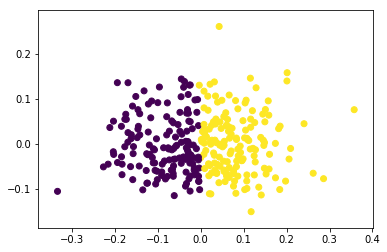

Comparing k-means clusters against the data:
col_0   0   1
row_0        
0      84  65
1      55  99


In [9]:
# normalize data
X_norm = normalize(X)

# reduce it to 2 components
X_pca = PCA(2).fit_transform(X_norm)

# calc predicted values
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

# plot the solution
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_pred)
plt.show()

# check solution against data
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred,y))

Looks like this model isn't doing very well. We're correctly classifying 183 cases, but mis-classifying 120 of the cases!

Now let's try MiniBatch:

In [10]:
# each batch will be made up of 200 data points
minibatchkmeans = MiniBatchKMeans(init='random',
                                  n_clusters=2,
                                  batch_size=200)
minibatchkmeans.fit(X_pca)

# Add new predicted cluster memberships to df
predict_mini = minibatchkmeans.predict(X_pca)

# check the mnibatch model against earlier one
print('Comparing K-means and mini batch kmeans solutions:')
print(pd.crosstab(predict_mini, y_pred))

Comparing K-means and mini batch kmeans solutions:
col_0    0    1
row_0          
0        8  153
1      141    1


This marks a significant change. How substantial is the computational performance improvement? Try re-running the $k$-means and mini batch $k$-means models and timing their execution. Check out the [%timeit magic](https://ipython.org/ipython-doc/3/interactive/magics.html#magic-timeit) for helpful timing tools.

### More clusters?

Let's see what happens when we change the value of $k$. What solution, if any, do we find most compelling? Does complexity start to become an issue with this data set? It may be possible to have a solution with more than two clusters that is still better at tracking the real binary outcome – two of those clusters may map to "heart disease" while the other maps to "no heart disease," for example.

In [13]:
df = pd.read_csv("https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/cleveland.csv", header=None, error_bad_lines=False)

X = df.iloc[:, :13]
y = df.iloc[:, 13]

# replace missing values (?) with 0
X = X.replace(to_replace='?', value=0)

# binarize y so that 1 means heart disease and 0 means no
y = np.where(y>0, 0, 1)

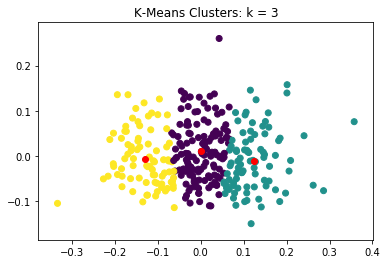

Comparing K-Means Clusters Against the Data:
col_0    0    1  All
row_0               
0       65   70  135
1       25   61   86
2       49   33   82
All    139  164  303


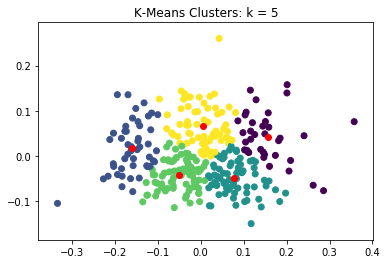

Comparing K-Means Clusters Against the Data:
col_0    0    1  All
row_0               
0       15   21   36
1       36   12   48
2       14   58   72
3       34   45   79
4       40   28   68
All    139  164  303


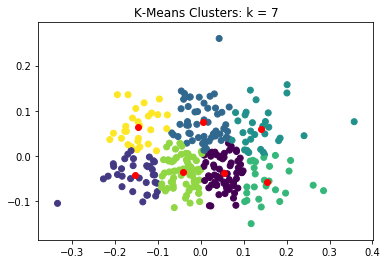

Comparing K-Means Clusters Against the Data:
col_0    0    1  All
row_0               
0       14   48   62
1       19   15   34
2       34   20   54
3       16   15   31
4        3   23   26
5       31   37   68
6       22    6   28
All    139  164  303


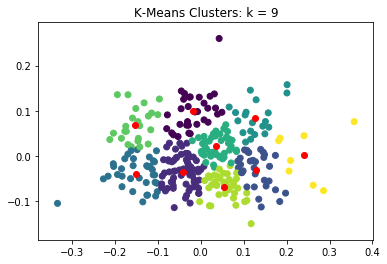

Comparing K-Means Clusters Against the Data:
col_0    0    1  All
row_0               
0       19   13   32
1       32   35   67
2        8   24   32
3       20   16   36
4       13    7   20
5       20   25   45
6       20    4   24
7        6   33   39
8        1    7    8
All    139  164  303


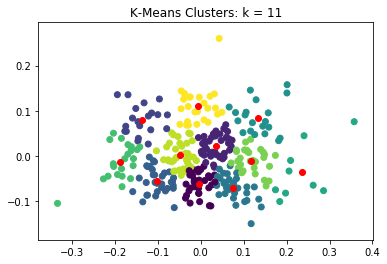

Comparing K-Means Clusters Against the Data:
col_0    0    1  All
row_0               
0       11   21   32
1       18   23   41
2       17    3   20
3       11   21   32
4        5   28   33
5       13    7   20
6        0    9    9
7       16    6   22
8        9   21   30
9       25   14   39
10      14   11   25
All    139  164  303


In [19]:
import time

# normalize data
X_norm = normalize(X)

# reduce it to 2 components using PCA
X_pca = PCA(2).fit_transform(X_norm)

#start = time.time()

K_vals = [3,5,7,9,11]

for i in K_vals:
    y_pred = KMeans(n_clusters=i, random_state=42).fit_predict(X_pca)
    estimator = KMeans(n_clusters=i, random_state=42).fit(X_pca)
    centers = estimator.cluster_centers_


    # plot
    plt.scatter(X_pca[:,0], X_pca[:,1], c=y_pred)
    plt.scatter(centers[:,0], centers[:,1], c='r')
    plt.title('K-Means Clusters: k = {}'.format(i))
    plt.show()

    # check the solutions against data
    print('Comparing K-Means Clusters Against the Data:')
    print(pd.crosstab(y_pred,y, margins=True))

#end = time.time()- start
#print('Run time: {:.2} secs'.format(end))

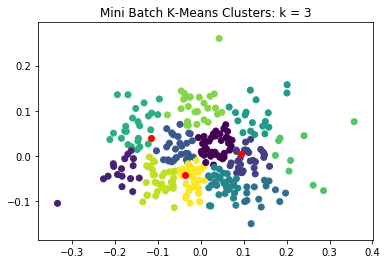

Comparing Mini Batch Kmeans Agaist the Data:
col_0    0    1  All
row_0               
0       42   57   99
1       52   23   75
2       45   84  129
All    139  164  303


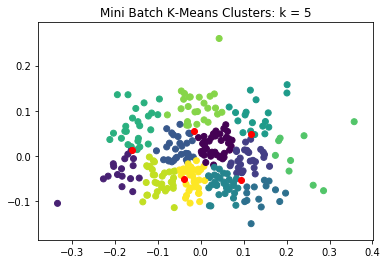

Comparing Mini Batch Kmeans Agaist the Data:
col_0    0    1  All
row_0               
0       39   28   67
1       23   23   46
2       12   53   65
3       30   46   76
4       35   14   49
All    139  164  303


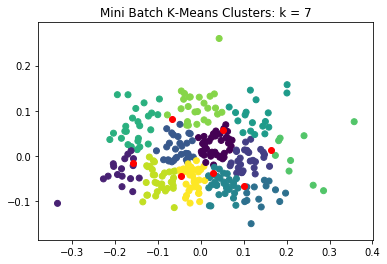

Comparing Mini Batch Kmeans Agaist the Data:
col_0    0    1  All
row_0               
0       29   16   45
1        6   30   36
2       13   37   50
3       27   17   44
4        9   22   31
5       28   12   40
6       27   30   57
All    139  164  303


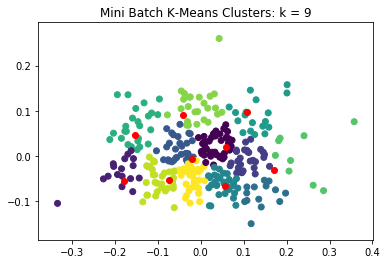

Comparing Mini Batch Kmeans Agaist the Data:
col_0    0    1  All
row_0               
0       18   11   29
1       15    8   23
2        5   23   28
3        9   38   47
4       18   25   43
5        9    8   17
6       22    6   28
7       26   21   47
8       17   24   41
All    139  164  303


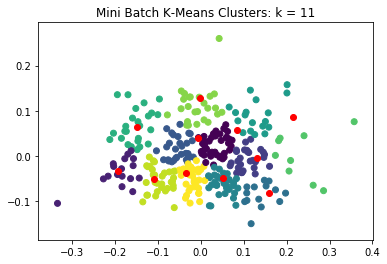

Comparing Mini Batch Kmeans Agaist the Data:
col_0    0    1  All
row_0               
0        9   19   28
1        2   15   17
2       22   17   39
3       21    6   27
4       10    7   17
5       17   12   29
6        4    5    9
7        5   16   21
8       12    3   15
9        9   37   46
10      28   27   55
All    139  164  303


In [21]:
K_vals = [3,5,7,9,11]

for i in K_vals:
    # each batch will be made up of 200 data points
    minibatchkmeans = MiniBatchKMeans(init='random',
                                  n_clusters=i,
                                  batch_size=200)
    minibatchkmeans.fit(X_pca)
    centers = minibatchkmeans.cluster_centers_

    # Add new predicted cluster memberships to df
    predict_mini = minibatchkmeans.predict(X_pca) 
    
    # plot
    plt.scatter(X_pca[:,0], X_pca[:,1], c=y_pred)
    plt.scatter(centers[:,0], centers[:,1], c='r')
    plt.title('Mini Batch K-Means Clusters: k = {}'.format(i))
    plt.show()   

    # check the mnibatch model against earlier one
    print('Comparing Mini Batch Kmeans Agaist the Data:')
    print(pd.crosstab(predict_mini, y, margins=True))

I find my solution for k=5 using KMeans most compelling. Complexity becomes an issue since overfitting occurs and centroids get assigned to outliers like at k=11. 